# Classification with Dynamic Time Warping

## Setup

In [14]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import dtw
from statistics import mode
import utils
import os
import time

RESULTS_DIR = "results"
DATA_PICKLE_FILE = "generated_data/HMM_data_ntrain5_1658502416.pkl"
CLS_NAME = "DTW"
SPLIT_ID = 0

## Load data

In [15]:
with open(DATA_PICKLE_FILE, "rb") as f:
    data = pickle.load(f)

data.keys()

dict_keys(['generating_model', 'data_filename', 'time_index', 'models_lst', 'labels_df', 'all_X_samples', 'all_Z_samples', 'indices_splits_lst', 'metadata'])

In [16]:
print(data["metadata"])

{'N_TRAIN_SAMPLES_PER_MODEL': 5, 'N_TEST_SAMPLES_PER_MODEL': 30, 'MAX_SAMPLE_LEN': 50, 'MIN_SAMPLE_LEN': 20}


In [17]:
indices_splits_lst = data["indices_splits_lst"]
all_X_samples = data["all_X_samples"]
labels_df = data["labels_df"]
current_split = indices_splits_lst[SPLIT_ID]
train_samples_ids = current_split["train_samples_ids"]
test_samples_ids = current_split["test_samples_ids"]

In [18]:
len(current_split["test_samples_ids"])

270

## Classify test samples with DTW
For each test sample find DTW distance to all samples in train subset and classify as the closest one's label.

In [19]:
# TODO try cross-validation to choose better k
def classify_sample(X: np.ndarray, train_samples: list[np.ndarray], train_labels: list[int], k: int = 1) -> int:
    """Classify a sample using DTW with k-NN based on samples in `train_samples`."""
    if k >= len(train_samples):
        raise ValueError("k >= number of train examples doesn't make sense in KNN-classifier.")
    distances = []
    for Y in train_samples:
        normalized_dist = dtw.dtw(X, Y, distance_only= True).normalizedDistance
        distances.append(normalized_dist)
    first_k = np.argsort(distances)[:k] # TODO optimize
    return(mode(train_labels[first_k]))

In [20]:
train_df = labels_df.loc[train_samples_ids]
train_ids = train_df.index.values.astype('int')
train_samples = [all_X_samples[id] for id in train_ids]
train_labels = train_df["true_label"].values

test_df = labels_df.loc[test_samples_ids]
test_ids = test_df.index.values.astype('int')
test_samples = [all_X_samples[id] for id in test_ids]

In [21]:
start = time.time()
predictions_1NN = [classify_sample(X, train_samples, train_labels, 1) for X in test_samples]
predictions_5NN = [classify_sample(X, train_samples, train_labels, 5) for X in test_samples]

df_1NN = pd.DataFrame({"pred": predictions_1NN}, index= test_df.index)
df_5NN = pd.DataFrame({"pred": predictions_5NN}, index= test_df.index)

stop = time.time()
total_time = stop - start
print(f"Time needed to classify all test samples: {total_time:.2f}s")

predictions_dfs = {
    "1NN": test_df.join(df_1NN),
    "5NN": test_df.join(df_5NN)
}

predictions_dfs["1NN"].head()

Time needed to classify all test samples: 1.97s


,sample_id,true_label,sample_len,pred
0,0,0,32,0
2,2,0,20,1
4,4,0,23,1
5,5,0,41,0
6,6,0,20,0


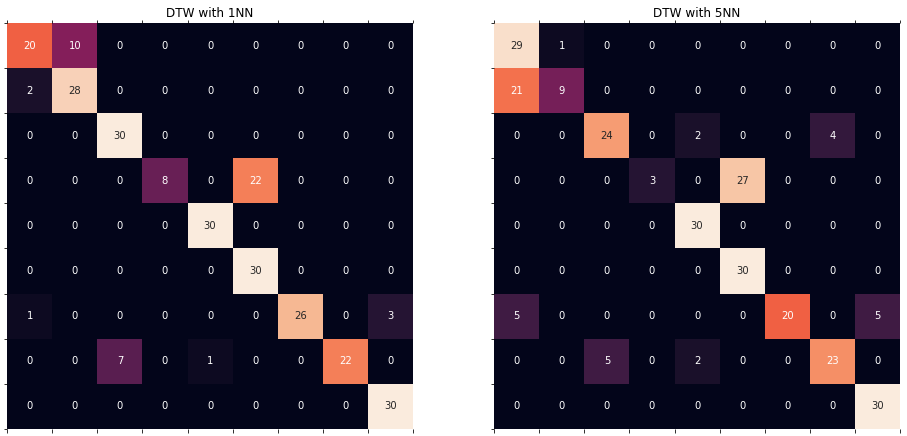

In [22]:
y_true = test_df["true_label"]
y_pred_1NN = predictions_dfs["1NN"]["pred"]
y_pred_5NN = predictions_dfs["5NN"]["pred"]

cm_1NN = confusion_matrix(y_true, y_pred_1NN)
cm_5NN = confusion_matrix(y_true, y_pred_5NN)

plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams['font.size'] = 10
fig, axes = plt.subplots(ncols = 2)
sns.heatmap(cm_1NN, annot=True, fmt='g', ax=axes[0], cbar = False)
axes[0].matshow(cm_1NN)
axes[0].set_title("DTW with 1NN")
sns.heatmap(cm_5NN, annot=True, fmt='g', ax=axes[1], cbar = False)
axes[1].matshow(cm_5NN)
axes[1].set_title("DTW with 5NN")
plt.show()

In [23]:
accuracies = dict()
for variant, df in predictions_dfs.items():
    acc = utils.accuracy(y_true, df["pred"])
    accuracies[variant] = acc
    print(f"{variant} accuracy: {acc:.4f}")

1NN accuracy: 0.8296
5NN accuracy: 0.7333


In [24]:
time_index = data["time_index"]
summary = {
    "data_filename": DATA_PICKLE_FILE,
    "classificator": CLS_NAME,
    "time_index": time_index,
    "split_id": SPLIT_ID,
    "predictions_dfs": predictions_dfs,
    "accuracies": accuracies,
    "total_time": total_time
}

for key, val in summary.items():
    print(f"{key}: {val}")

data_filename: generated_data/HMM_data_ntrain5_1658502416.pkl
time_index: 1658502416
split_id: 0
predictions_dfs: {'1NN':      sample_id  true_label  sample_len  pred
0            0           0          32     0
2            2           0          20     1
4            4           0          23     1
5            5           0          41     0
6            6           0          20     0
..         ...         ...         ...   ...
309        309           8          47     8
310        310           8          26     8
311        311           8          44     8
313        313           8          50     8
314        314           8          35     8

[270 rows x 4 columns], '5NN':      sample_id  true_label  sample_len  pred
0            0           0          32     0
2            2           0          20     0
4            4           0          23     0
5            5           0          41     0
6            6           0          20     0
..         ...         ...         .

In [25]:
gen_type = data["generating_model"]
split_id_str = str(SPLIT_ID)
if len(split_id_str) == 1:
    split_id_str = "0" + split_id_str

output_path = f"{RESULTS_DIR}/dtw_results_for_{gen_type}_{time_index}_{split_id_str}.pkl"
if os.path.exists(output_path):
    inp = input(f"Classification results {output_path} already exists. Do you want to overwrite it? (y = yes)")
    if inp in ["y", "Y"]:
        with open(output_path, 'wb') as f:
                pickle.dump(summary, f)
                print(f"Updated classification results saved to {output_path}.")
    else:
        print("Canceled.")
else:
    with open(output_path, 'wb') as f:
        pickle.dump(summary, f)
        print(f"Classification results saved to {output_path}.")

Updated classification results saved to results/dtw_results_for_HMM_1658502416_00.pkl.
